In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

2023-10-11 13:37:26.072752: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 13:37:26.136790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:37:27.349677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Library Versions:
numpy: 1.26.0
pandas: 2.1.1
tensorflow: 2.13.1
tensorflow probability: 0.21.0


In [2]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.data_generators import KerasDataGenerator
from art.defences.trainer import AdversarialTrainer

In [3]:
n_epochs = 200
verbose_option = True

# Classification for Ship Detection


Load Ship Detection Dataset

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
BATCH_SIZE=1000
def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'categorical',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


2023-10-11 13:37:32.972678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9


In [5]:
x_train, y_train = list(train_dataset.as_numpy_iterator())[0]
x_test, y_test = list(test_dataset.as_numpy_iterator())[0]

Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [6]:
def build_model():
    inputs = layers.Input(shape=(80,80,3))
    flat = layers.Flatten()(inputs)
    h1 = layers.Dense(50, activation="relu")(flat) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on the flattened input
    h2 = layers.Dense(50, activation="relu")(h1) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on h1
    h3 = layers.Dense(50, activation="relu")(h2) #TODO: Call a Keras Tensorflow Dense layer constructor for 50 ReLU neurons and call it on h2
    p = layers.Dense(2,activation=tf.keras.activations.softmax)(h3) #TODO: Call the Dense layer constructor to compute the prediction for p(y=1|x,theta)

    model = keras.Model(inputs=inputs, outputs=p)

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.CategoricalCrossentropy(from_logits=False)]
    )
    return model

In [7]:
model = build_model()

In [8]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)#verbose_option)

Epoch 1/200


2023-10-11 13:37:37.901859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-11 13:37:37.910024: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbce0037610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 13:37:37.910050: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-10-11 13:37:37.916725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 13:37:38.147679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-11 13:37:38.415163: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

4/4 [==============================] - 4s 20ms/step - loss: 1.9844 - categorical_accuracy: 0.7359 - categorical_crossentropy: 1.9844
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.8281 - categorical_accuracy: 0.6028 - categorical_crossentropy: 0.8281
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.6733 - categorical_accuracy: 0.5791 - categorical_crossentropy: 0.6733
Epoch 4/200
4/4 [==============================] - 0s 17ms/step - loss: 0.5617 - categorical_accuracy: 0.7575 - categorical_crossentropy: 0.5617
Epoch 5/200
4/4 [==============================] - 0s 17ms/step - loss: 0.5376 - categorical_accuracy: 0.8125 - categorical_crossentropy: 0.5376
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4874 - categorical_accuracy: 0.7684 - categorical_crossentropy: 0.4874
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4816 - categorical_accuracy: 0.8263 - categorical_crossentropy: 0.48

4/4 [==============================] - 0s 16ms/step - loss: 0.2528 - categorical_accuracy: 0.8994 - categorical_crossentropy: 0.2528
Epoch 58/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2510 - categorical_accuracy: 0.8997 - categorical_crossentropy: 0.2510
Epoch 59/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2495 - categorical_accuracy: 0.9009 - categorical_crossentropy: 0.2495
Epoch 60/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2483 - categorical_accuracy: 0.9022 - categorical_crossentropy: 0.2483
Epoch 61/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2466 - categorical_accuracy: 0.9028 - categorical_crossentropy: 0.2466
Epoch 62/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2450 - categorical_accuracy: 0.9034 - categorical_crossentropy: 0.2450
Epoch 63/200
4/4 [==============================] - 0s 16ms/step - loss: 0.2433 - categorical_accuracy: 0.9044 - categorical_crossentropy

4/4 [==============================] - 0s 16ms/step - loss: 0.1955 - categorical_accuracy: 0.9247 - categorical_crossentropy: 0.1955
Epoch 114/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1947 - categorical_accuracy: 0.9256 - categorical_crossentropy: 0.1947
Epoch 115/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1943 - categorical_accuracy: 0.9256 - categorical_crossentropy: 0.1943
Epoch 116/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1942 - categorical_accuracy: 0.9241 - categorical_crossentropy: 0.1942
Epoch 117/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1925 - categorical_accuracy: 0.9259 - categorical_crossentropy: 0.1925
Epoch 118/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1933 - categorical_accuracy: 0.9247 - categorical_crossentropy: 0.1933
Epoch 119/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1912 - categorical_accuracy: 0.9272 - categorical_crosse

4/4 [==============================] - 0s 16ms/step - loss: 0.1723 - categorical_accuracy: 0.9325 - categorical_crossentropy: 0.1723
Epoch 169/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1650 - categorical_accuracy: 0.9347 - categorical_crossentropy: 0.1650
Epoch 170/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1590 - categorical_accuracy: 0.9366 - categorical_crossentropy: 0.1590
Epoch 171/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1542 - categorical_accuracy: 0.9416 - categorical_crossentropy: 0.1542
Epoch 172/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1522 - categorical_accuracy: 0.9413 - categorical_crossentropy: 0.1522
Epoch 173/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1524 - categorical_accuracy: 0.9416 - categorical_crossentropy: 0.1524
Epoch 174/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1515 - categorical_accuracy: 0.9428 - categorical_crosse

Evaluate the classification model on the test data

In [9]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 211ms/step - loss: 0.2021 - categorical_accuracy: 0.9262 - categorical_crossentropy: 0.2021


[0.2020844668149948, 0.9262499809265137, 0.2020844668149948]

1. Train a classifier using FGSM-based adversarial training

In [10]:
classifier = TensorFlowV2Classifier(build_model(), nb_classes=2, input_shape=[80,80,3],loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),optimizer=tf.keras.optimizers.Adam(1e-3), clip_values=(0, 1))

In [11]:
fgsm = FastGradientMethod(classifier,eps=0.02,eps_step = 0.01,batch_size=x_train.shape[0])

In [12]:
adv_trainer = AdversarialTrainer(classifier, attacks=fgsm, ratio=0.5)

In [13]:
adv_trainer.fit(x=x_train,y=y_train, batch_size=x_train.shape[0], nb_epochs=n_epochs)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [15]:
(np.argmax(classifier.predict(examples),axis=1)==np.argmax(labels,axis=1)).mean()

0.875

Evaluate the standard classification model on a test example and 0-targeted FGSM examples using epislons of 0.01, 0.03, and 0.1

In [16]:
model(np.reshape(examples[0],[1,80,80,3])).numpy()[0]

array([0.10199019, 0.89800984], dtype=float32)

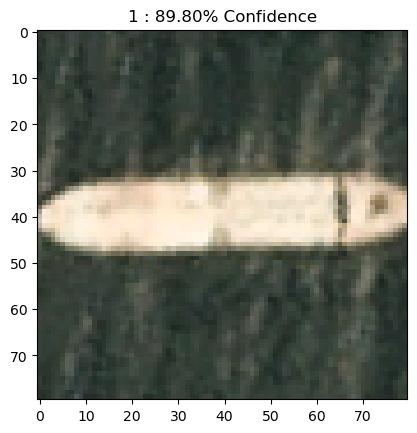

In [17]:
plt.figure()
plt.imshow(examples[5])
confidence = model(np.reshape(examples[0],[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [18]:
def create_adversarial_pattern(model,input_example, target,loss_object):
    input_example = tf.convert_to_tensor(input_example)
    with tf.GradientTape() as tape:
        tape.watch(input_example)
        prediction = model(input_example)
        loss = loss_object(target, prediction)

        # Get the gradients of the loss w.r.t to the input example.
        gradient = tape.gradient(loss, input_example)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
    return signed_grad

In [19]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
signed_grad_np = create_adversarial_pattern(model,np.reshape(examples[5],[1,80,80,3]), np.array([[1,0]]),loss_object)

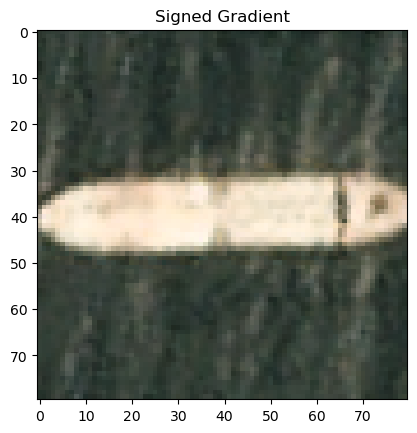

In [20]:
plt.figure()
plt.imshow(examples[5])
plt.title('Signed Gradient')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


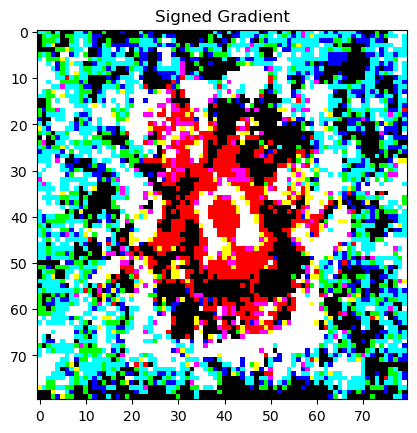

In [21]:
plt.figure()
plt.imshow(signed_grad_np[0])
plt.title('Signed Gradient')
plt.show()

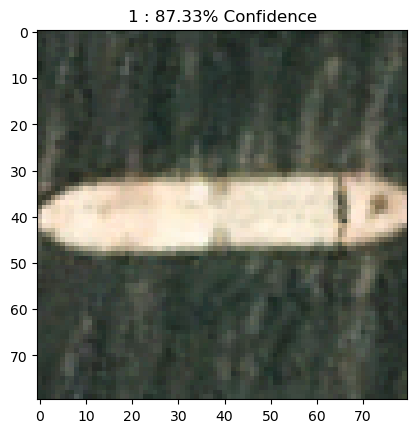

In [22]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.01
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

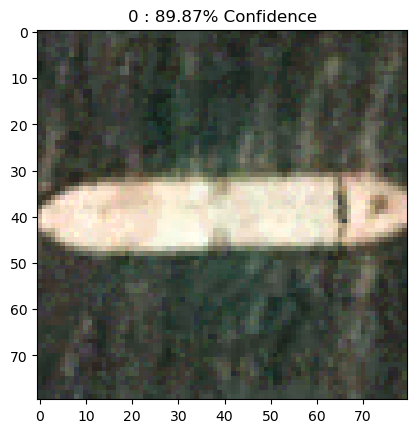

In [23]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.03
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

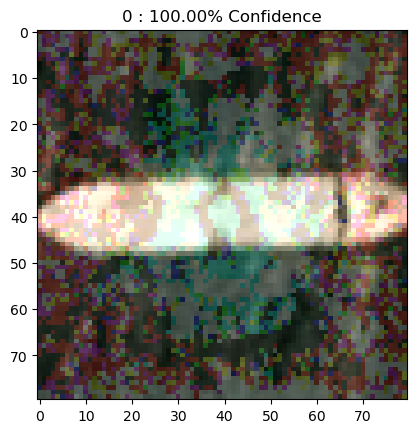

In [24]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.1
plt.imshow(np.clip(adv_example,0,1))
confidence = model(np.reshape(adv_example,[1,80,80,3])).numpy()[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

2. Evaluate the classification model with adversarial training on a test example and 0-targeted FGSM examples using epislons of 0.01, 0.03, and 0.1

In [25]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
signed_grad_np = create_adversarial_pattern(classifier.model,np.reshape(examples[5],[1,80,80,3]), np.array([[1,0]]),loss_object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


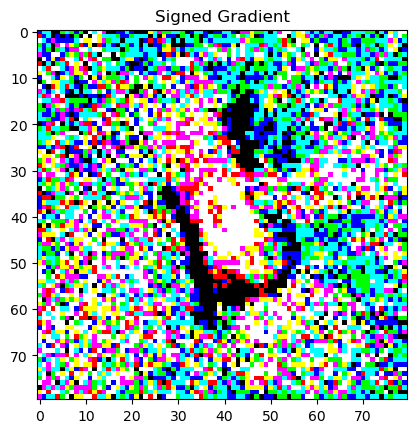

In [26]:
plt.figure()
plt.imshow(signed_grad_np[0])
plt.title('Signed Gradient')
plt.show()

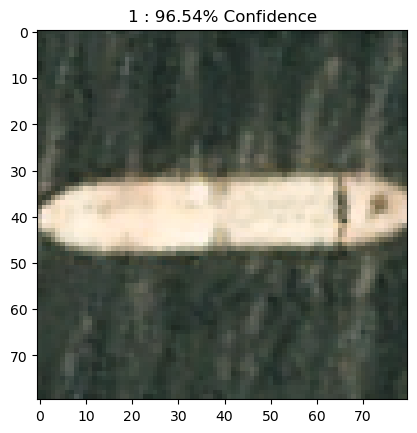

In [27]:
plt.figure()
plt.imshow(examples[5])
confidence = classifier.predict(np.reshape(examples[5],[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

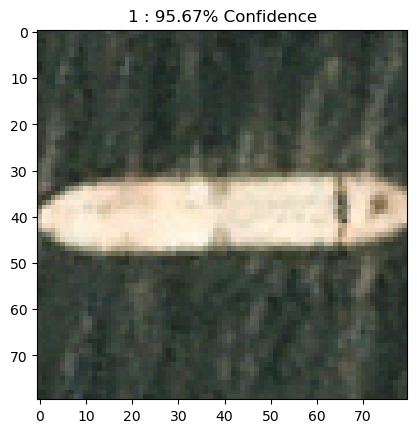

In [28]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.01
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

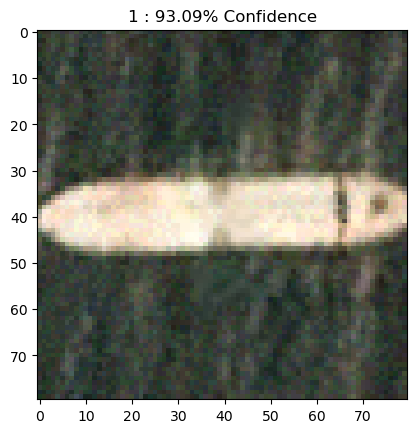

In [29]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.03
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

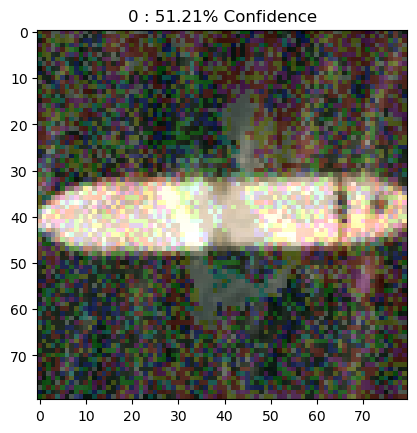

In [30]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.1
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

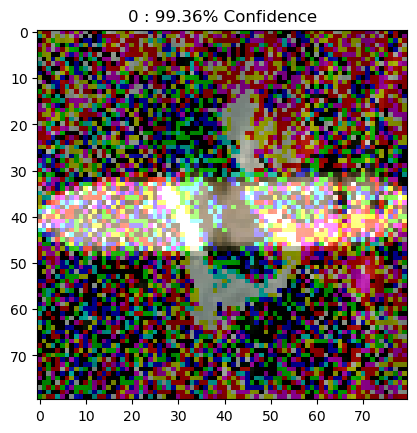

In [31]:
plt.figure()
adv_example = examples[5]-signed_grad_np[0]*0.3
plt.imshow(np.clip(adv_example,0,1))
confidence = classifier.predict(np.reshape(adv_example,[1,80,80,3]))[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()